In [1]:
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import LSTM, Input, Masking
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import keras

In [2]:
from pointer_lstm import PointerDecoder
from sorting_dataset import gen_data, gen_jagged_data

In [3]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [4]:
%reload_ext autoreload
%autoreload 2

np.random.seed(17)

In [5]:
N = 10000
max_seq_len = 5
output_size = max_seq_len

X, y = gen_data(N, max_seq_len, low=0, high=1000)
# X, y = gen_jagged_data(N, max_seq_len, low=1)

# Pad the jagged sequences
X = pad_sequences(X, maxlen=max_seq_len, value=-1, padding='post', truncating='post', dtype=np.float32)
y = pad_sequences(y, maxlen=max_seq_len, value=-1, padding='post', truncating='post')

# Shuffle the sequences
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

X.shape, y.shape

((10000, 5), (10000, 5))

In [6]:
X[:2], y[:2]

(array([[562.,  92., 269., 510., 332.],
        [209., 553., 705., 294., 319.]], dtype=float32),
 array([[1, 2, 4, 3, 0],
        [0, 3, 4, 1, 2]], dtype=int32))

In [18]:
split = int(0.8 * N)

_X = X / np.expand_dims(X.max(axis=1), axis=1)
_X = np.expand_dims(_X, axis=2)
# _X = np.repeat(_X, 4, axis=2)

# OHE the labels
_y = to_categorical(y, num_classes=max_seq_len+1)
_y = _y[:, :output_size, :max_seq_len]

X_train = _X[:split]
y_train = _y[:split]

X_test = _X[split:]
y_test = _y[split:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 5, 1), (8000, 5, 5), (2000, 5, 1), (2000, 5, 5))

In [8]:
seq_shape = X_train.shape[1:]
hidden_units = 32
batch_size = 16

inputs = Input(shape=seq_shape, name='input', batch_size=batch_size)
masking = Masking(mask_value=-1, name='masking') 
masked = masking(inputs)
encoder = LSTM(hidden_units, name='encoder', return_sequences=True, return_state=True)
enc, state_h, state_c =  encoder(masked)

decoder = PointerDecoder(hidden_units, output_size=output_size, name='decoder')
dec = decoder(enc, initial_state=[state_h, state_c])

model = Model(inputs, dec)
model.summary()

2021-12-20 00:18:56.175287: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(16, 5, 1)]         0           []                               
                                                                                                  
 masking (Masking)              (16, 5, 1)           0           ['input[0][0]']                  
                                                                                                  
 encoder (LSTM)                 [(16, 5, 32),        4352        ['masking[0][0]']                
                                 (16, 32),                                                        
                                 (16, 32)]                                                        
                                                                                              

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
nb_epochs = 20
h = model.fit(X_train, y_train,
            epochs=nb_epochs, batch_size=batch_size)

Epoch 1/20
500/500 [==============================] - 12s 6ms/step - loss: 0.8901 - accuracy: 0.6044
Epoch 2/20
500/500 [==============================] - 3s 6ms/step - loss: 0.3143 - accuracy: 0.8799
Epoch 3/20
500/500 [==============================] - 3s 6ms/step - loss: 0.2202 - accuracy: 0.9195
Epoch 4/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1684 - accuracy: 0.9431
Epoch 5/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1401 - accuracy: 0.9528
Epoch 6/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1237 - accuracy: 0.9574
Epoch 7/20
500/500 [==============================] - 4s 7ms/step - loss: 0.1150 - accuracy: 0.9587
Epoch 8/20
500/500 [==============================] - 4s 7ms/step - loss: 0.1013 - accuracy: 0.9640
Epoch 9/20
500/500 [==============================] - 4s 7ms/step - loss: 0.0992 - accuracy: 0.9641
Epoch 10/20
500/500 [==============================] - 3s 6ms/step - loss: 0.0890 - accuracy: 0.968

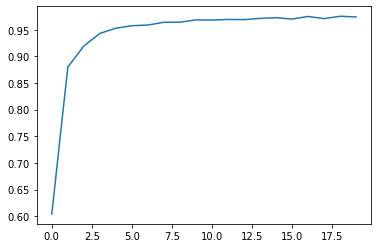

In [11]:
plt.plot(h.history['accuracy'])

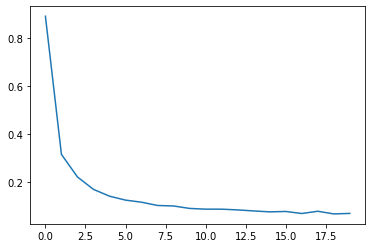

In [12]:
plt.plot(h.history['loss'])

In [13]:
model.evaluate(X_test[:-16], y_test[:-16], batch_size=batch_size)

124/124 [==============================] - 3s 3ms/step - loss: 0.0592 - accuracy: 0.9792


[0.0592058040201664, 0.9792338609695435]

In [14]:
X_test[:2]

array([[[0.36646587],
        [0.9146586 ],
        [0.19477911],
        [1.        ],
        [0.8303213 ]],

       [[0.8847118 ],
        [0.10651629],
        [0.7017544 ],
        [0.7744361 ],
        [1.        ]]], dtype=float32)

In [19]:
X_test.shape

(2000, 5, 1)

In [21]:
y_pred = model.predict(X_test[:-16])

In [22]:
y_pred_pos = y_pred.argmax(axis=2)
y_pred_idx = y_pred.argmax(axis=1)
y_pred_pos[:2], y_pred_idx[:2]

(array([[2, 0, 4, 1, 3],
        [1, 2, 3, 0, 4]]),
 array([[1, 3, 0, 4, 2],
        [3, 0, 1, 2, 4]]))

In [23]:
def compute_accuracy(_y_true, _y_pred):
    acc = keras.metrics.Accuracy()
    return acc(_y_true, _y_pred).numpy()

In [24]:
compute_accuracy(y_pred_idx.argsort(), y_pred_pos)

0.9892137

In [25]:
y_test_pos = y_test.argmax(axis=2)
y_test_idx = y_test.argmax(axis=1)
y_test_pos[:2], y_test_idx[:2]

(array([[2, 0, 4, 1, 3],
        [1, 2, 3, 0, 4]]),
 array([[1, 3, 0, 4, 2],
        [3, 0, 1, 2, 4]]))

In [26]:
compute_accuracy(y_test_idx.argsort(), y_test_pos)

1.0

In [27]:
compute_accuracy(y_pred_pos, y_test_pos[:-16])

0.97923386

In [28]:
compute_accuracy(y_pred_idx, y_test_idx[:-16])

0.98467743

In [29]:
X_ = X_test[:batch_size]
X_[0] = [[0.2], [1.0], [-1], [-1], [-1]]
X_[1] = [[1.0], [1.0], [1.0], [1.0], [1.0]]
X_[2] = [[1], [0.1], [0.1], [1], [0.1]]

X[:3]

array([[562.,  92., 269., 510., 332.],
       [209., 553., 705., 294., 319.],
       [849., 439.,  19., 942., 271.]], dtype=float32)

In [30]:
y_pred = model.predict(X_)
y_pred_pos = y_pred.argmax(axis=2)
y_pred_idx = y_pred.argmax(axis=1)
y_pred_pos[:3], y_pred_idx[:3]

(array([[0, 0, 0, 1, 1],
        [0, 0, 1, 1, 1],
        [1, 1, 1, 0, 0]]),
 array([[0, 3, 0, 0, 0],
        [0, 3, 0, 0, 0],
        [4, 0, 0, 0, 0]]))

In [31]:
y_pred[:3]

array([[[1.0000000e+00, 9.0080521e-10, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [1.0000000e+00, 1.7694397e-16, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [9.9555439e-01, 4.4456460e-03, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [1.4198830e-15, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [2.6467728e-07, 9.9999976e-01, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00]],

       [[5.7554233e-01, 4.2445764e-01, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [5.1545984e-01, 4.8454013e-01, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [4.0086201e-01, 5.9913790e-01, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [3.7969685e-01, 6.2030315e-01, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00],
        [4.2294499e-01, 5.7705510e-01, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00]],

       [[2.3220254e-11, 1.0000000e+00, 0.0000000e+00, 0.